In [57]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import shapiro, normaltest
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error


## Przygotowanie lagów oraz kodowanie województw

Tworzenie 12-miesięcznych cech opóźnionych (lag_1 do lag_12) pozwala modelowi uczyć się na podstawie danych z poprzednich miesięcy. Zgony wykazują sezonowość i zależność czasową, takie cechy umożliwiają modelowi uchwycenie trendów i powtarzających się wzorców np. skok zgonów w zimie. Dla każdego rekordu model przewiduje liczbę zgonów, korzystając z wartości z poprzednich 12 miesięcy jako wejścia modelu

Model MLP nie przyjmuje zmiennych tekstowych, konieczne jest zastosowanie kodowania kolumny z nazwami województw. W efekcie powstanie nam 16 nowych kolumn binarnych, każda kolumna odpowiada jednemu województwowi

In [58]:
n_lags = 12
lagged_dfs = []
data_2 = pd.read_pickle("data_2.pkl")

for woj, group in data_2.groupby("Nazwa województwa"):
    group = group.sort_values(by=["Rok zgonu", "Miesiąc zgonu"]).copy()
    for lag in range(1, n_lags+1):
        group[f"lag_{lag}"] = group["Wskaznik_zgonow_ogolem"].shift(lag)
    lagged_dfs.append(group)

df_all = pd.concat(lagged_dfs)
df_all.reset_index(drop=True, inplace=True)
df_all_lags = df_all.dropna(subset=[f"lag_{i}" for i in range(1, 12+1)]).reset_index(drop=True)
df_all_lags

,Kod TERYT,Nazwa województwa,Rok zgonu,Miesiąc zgonu,Zgony kobiet Przedział wiekowy 0-64 lata,Zgony kobiet Przedział wiekowy 65 lat i więcej,Zgony mężczyn Przedział wiekowy 0-64 lata,Zgony mężczyzn Przedział wiekowy 65 lat i więcej,Zgony razem,Kod,...,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2,DOLNOŚLĄSKIE,2017,1,269,1522,548,1118,3457,200000,...,0.88232,0.801733,0.840304,0.805177,0.765572,0.844781,0.83135,0.891618,0.880253,0.927779
1,2,DOLNOŚLĄSKIE,2017,2,225,1305,458,987,2975,200000,...,0.862689,0.88232,0.801733,0.840304,0.805177,0.765572,0.844781,0.83135,0.891618,0.880253
2,2,DOLNOŚLĄSKIE,2017,3,208,1042,463,846,2559,200000,...,0.890585,0.862689,0.88232,0.801733,0.840304,0.805177,0.765572,0.844781,0.83135,0.891618
3,2,DOLNOŚLĄSKIE,2017,4,206,952,445,776,2379,200000,...,1.191023,0.890585,0.862689,0.88232,0.801733,0.840304,0.805177,0.765572,0.844781,0.83135
4,2,DOLNOŚLĄSKIE,2017,5,188,981,502,748,2419,200000,...,1.024962,1.191023,0.890585,0.862689,0.88232,0.801733,0.840304,0.805177,0.765572,0.844781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,26,ŚWIĘTOKRZYSKIE,2024,8,64,503,164,442,1173,2600000,...,1.008643,1.003462,1.057003,1.082046,1.137315,1.18357,1.066325,1.014977,0.885752,0.918272
1532,26,ŚWIĘTOKRZYSKIE,2024,9,53,480,163,427,1123,2600000,...,0.924014,1.008643,1.003462,1.057003,1.082046,1.137315,1.18357,1.066325,1.014977,0.885752
1533,26,ŚWIĘTOKRZYSKIE,2024,10,71,558,159,497,1285,2600000,...,0.915378,0.924014,1.008643,1.003462,1.057003,1.082046,1.137315,1.18357,1.066325,1.014977
1534,26,ŚWIĘTOKRZYSKIE,2024,11,50,490,169,413,1122,2600000,...,1.012961,0.915378,0.924014,1.008643,1.003462,1.057003,1.082046,1.137315,1.18357,1.066325


In [59]:
# One-hot encoding województw
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_woj_onehot = encoder.fit_transform(df_all_lags[["Nazwa województwa"]])

#Miesiąc cyclical
df_all_lags["month_sin"] = np.sin(2 * np.pi * df_all_lags["Miesiąc zgonu"]/12)
df_all_lags["month_cos"] = np.cos(2 * np.pi * df_all_lags["Miesiąc zgonu"]/12)

In [60]:
#lag features i miesiąc
lag_cols = [f"lag_{i}" for i in range(1, 13)]
X_lags = df_all_lags[lag_cols].values
X_month = df_all_lags[["month_sin", "month_cos"]].values
y = df_all_lags["Wskaznik_zgonow_ogolem"].values

## Skalowanie

Skalowanie danych do średniej 0 i odchylenia 1 jest ważne w sieciach neuronowych, <br>
ponieważ poprawia stabilność numeryczną, przyspiesza uczenie i zapobiega dominacji cech o większych wartościach nad pozostałymi

In [61]:
scaler_X = StandardScaler()
X_lags_scaled = scaler_X.fit_transform(X_lags)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1,1))

X_all = np.hstack([X_woj_onehot, X_lags_scaled, X_month])

In [62]:
train_idx = df_all_lags["Rok zgonu"] < 2023
val_idx = df_all_lags["Rok zgonu"] == 2023

X_train = X_all[train_idx]
y_train = y_scaled[train_idx]
X_val = X_all[val_idx]
y_val = y_scaled[val_idx]

In [63]:
train_idx

0        True
1        True
2        True
3        True
4        True
        ...  
1531    False
1532    False
1533    False
1534    False
1535    False
Name: Rok zgonu, Length: 1536, dtype: bool

In [64]:
input_dim = X_train.shape[1] #liczba cech

input_layer = Input(shape=(input_dim,))
x = Dense(12, activation='relu')(input_layer)
x = Dropout(0.2)(x)
output = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 12)                  │             372 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              13 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 385 (1.50 KB)

 Trainable params: 385 (1.50 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=12, callbacks=[early_stop], verbose=2,shuffle=False)


Epoch 1/200
96/96 - 1s - 6ms/step - loss: 0.8839 - val_loss: 0.2398
Epoch 2/200
96/96 - 0s - 1ms/step - loss: 0.7183 - val_loss: 0.2168
Epoch 3/200
96/96 - 0s - 1ms/step - loss: 0.6190 - val_loss: 0.2089
Epoch 4/200
96/96 - 0s - 1ms/step - loss: 0.5735 - val_loss: 0.2017
Epoch 5/200
96/96 - 0s - 1ms/step - loss: 0.5205 - val_loss: 0.1964
Epoch 6/200
96/96 - 0s - 1ms/step - loss: 0.5080 - val_loss: 0.1933
Epoch 7/200
96/96 - 0s - 1ms/step - loss: 0.4837 - val_loss: 0.1931
Epoch 8/200
96/96 - 0s - 1ms/step - loss: 0.4365 - val_loss: 0.1877
Epoch 9/200
96/96 - 0s - 1ms/step - loss: 0.4281 - val_loss: 0.1872
Epoch 10/200
96/96 - 0s - 1ms/step - loss: 0.4061 - val_loss: 0.1812
Epoch 11/200
96/96 - 0s - 1ms/step - loss: 0.4196 - val_loss: 0.1820
Epoch 12/200
96/96 - 0s - 1ms/step - loss: 0.3851 - val_loss: 0.1804
Epoch 13/200
96/96 - 0s - 1ms/step - loss: 0.3956 - val_loss: 0.1725
Epoch 14/200
96/96 - 0s - 1ms/step - loss: 0.3899 - val_loss: 0.1651
Epoch 15/200
96/96 - 0s - 1ms/step - loss: 

### Straty treningowe i walidacyjne

**Strata treningowa (training loss)** i **strata walidacyjna (validation loss)** to dwa kluczowe wskaźniki używane do monitorowania wydajności modelu oraz jego zdolności do uogólniania wyników

**Strata treningowa** odnosi się do błędu popełnianego na danych, na których model był trenowany.

**Strata walidacyjna** to błąd na danych niewidzianych wcześniej, używanych do oceny, jak dobrze model radzi sobie poza zbiorem treningowym.

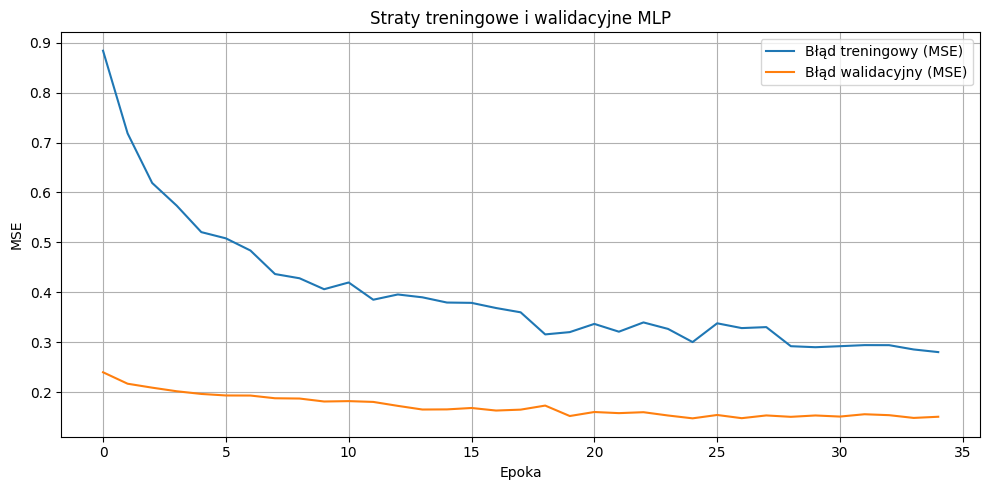

In [66]:
plt.figure(figsize=(10,5))
plt.plot(history.history["loss"], label="Błąd treningowy (MSE)")
plt.plot(history.history["val_loss"], label="Błąd walidacyjny (MSE)")
plt.xlabel("Epoka")
plt.ylabel("MSE")
plt.title("Straty treningowe i walidacyjne MLP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Conformal prediction
Jest to metoda kwantyfikacji niepewności wykorzystywana w przewidywaniach modeli uczenia maszynowego, <br>
która zamiast pojedynczych wyników generuje zbiór możliwych przewidywań. <br>
Działa w oparciu o wyniki modelu na zbiorze walidacyjnym oblicza, jak bardzo prognozy różnią się od rzeczywistych wartości,<br>
a następnie tworzy przedział, w którym z określonym prawdopodobieństwem znajdzie się prawdziwa wartość.

In [67]:
y_val_pred_scaled = model.predict(X_val, verbose=0)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
y_val_true = scaler_y.inverse_transform(y_val)

mask_val = df_all_lags["Rok zgonu"] == 2023

y_val_df = df_all_lags[mask_val][["Nazwa województwa"]].reset_index(drop=True)
y_val_df["y_true"] = y_val_true
y_val_df["y_pred"] = y_val_pred

errors_by_woj = {}

for woj in encoder.categories_[0]:
    mask = (y_val_df["Nazwa województwa"] == woj).values
    errs = np.abs(y_val_df["y_true"][mask] - y_val_df["y_pred"][mask])
    errors_by_woj[woj] = errs.values

# --- 3. Kwantyl 95% osobno dla województw ---
q_by_woj = {
    woj: np.percentile(errs, 95)
    for woj, errs in errors_by_woj.items()
}

In [68]:
df_forecast_cp = []

for i, woj in enumerate(encoder.categories_[0]):
    df_w = df_all_lags[(df_all_lags["Nazwa województwa"] == woj) & (df_all_lags["Rok zgonu"] == 2023)]
    last_12 = df_w.sort_values("Miesiąc zgonu")["Wskaznik_zgonow_ogolem"].values[-12:]
    woj_onehot = X_woj_onehot[df_all_lags["Nazwa województwa"]==woj][0].reshape(1,-1)

    for month in range(1, 13):
        month_sin = np.sin(2*np.pi*month/12)
        month_cos = np.cos(2*np.pi*month/12)
        X_month_pred = np.array([[month_sin, month_cos]])

        X_lags_pred = scaler_X.transform(last_12.reshape(1,-1))

        X_pred = np.hstack([woj_onehot, X_lags_pred, X_month_pred])
        y_pred_scaled = model.predict(X_pred, verbose=0)
        y_pred = scaler_y.inverse_transform(y_pred_scaled)[0,0]

        #PRZEDZIAŁ UFNOŚCI DLA WOJEWÓDZTWA
        q = q_by_woj[woj]
        lower_pred = y_pred - q
        upper_pred = y_pred + q

        df_forecast_cp.append({
            "Województwo": woj,
            "Rok zgonu": 2024,
            "Miesiąc zgonu": month,
            "Pred_mean": y_pred,
            "Pred_lower": lower_pred,
            "Pred_upper": upper_pred
        })

        last_12 = np.roll(last_12, -1)
        last_12[-1] = y_pred

df_forecast_cp = pd.DataFrame(df_forecast_cp)

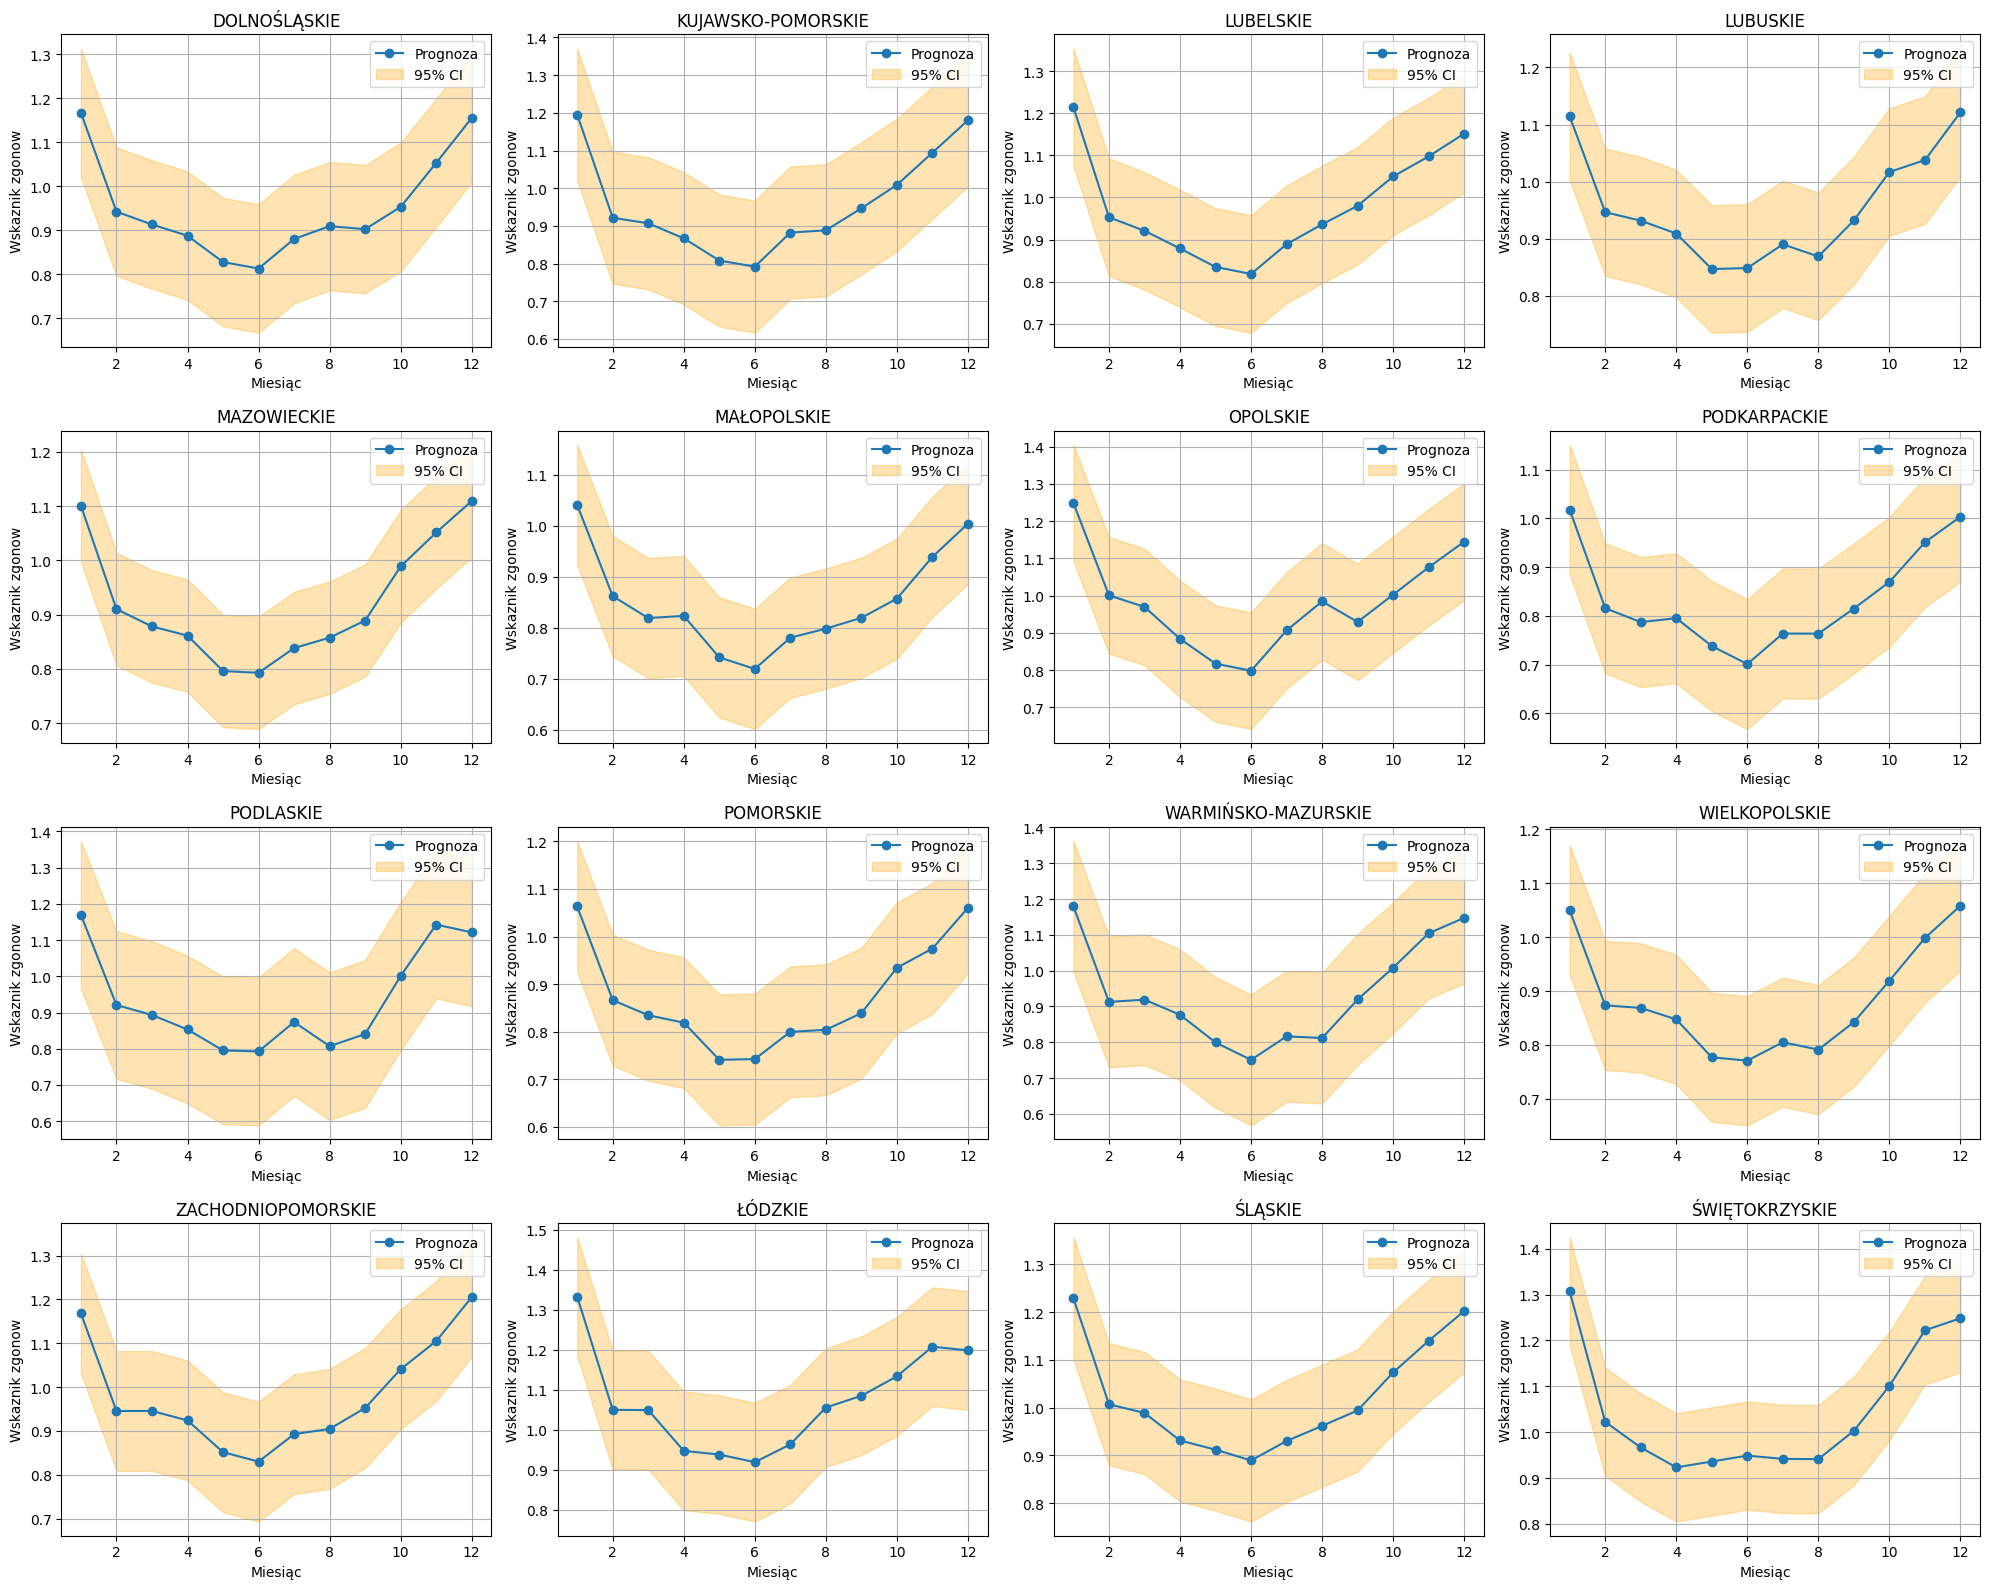

In [70]:
wojewodztwa = df_forecast_cp["Województwo"].unique()
fig, axes = plt.subplots(4,4, figsize=(20,16), sharey=False)
axes = axes.flatten()

for i, woj in enumerate(wojewodztwa):
    df_w = df_forecast_cp[df_forecast_cp["Województwo"]==woj].sort_values("Miesiąc zgonu")
    axes[i].plot(df_w["Miesiąc zgonu"], df_w["Pred_mean"], marker="o", label="Prognoza")
    axes[i].fill_between(df_w["Miesiąc zgonu"], df_w["Pred_lower"], df_w["Pred_upper"], 
                         alpha=0.3, color="orange", label="95% CI")
    axes[i].set_title(woj)
    axes[i].set_xlabel("Miesiąc")
    axes[i].set_ylabel("Wskaznik zgonow")
    axes[i].grid(True)
    axes[i].legend()
    

plt.tight_layout()
plt.savefig("wykres_wojewodztwa.png", dpi=300)
plt.show()

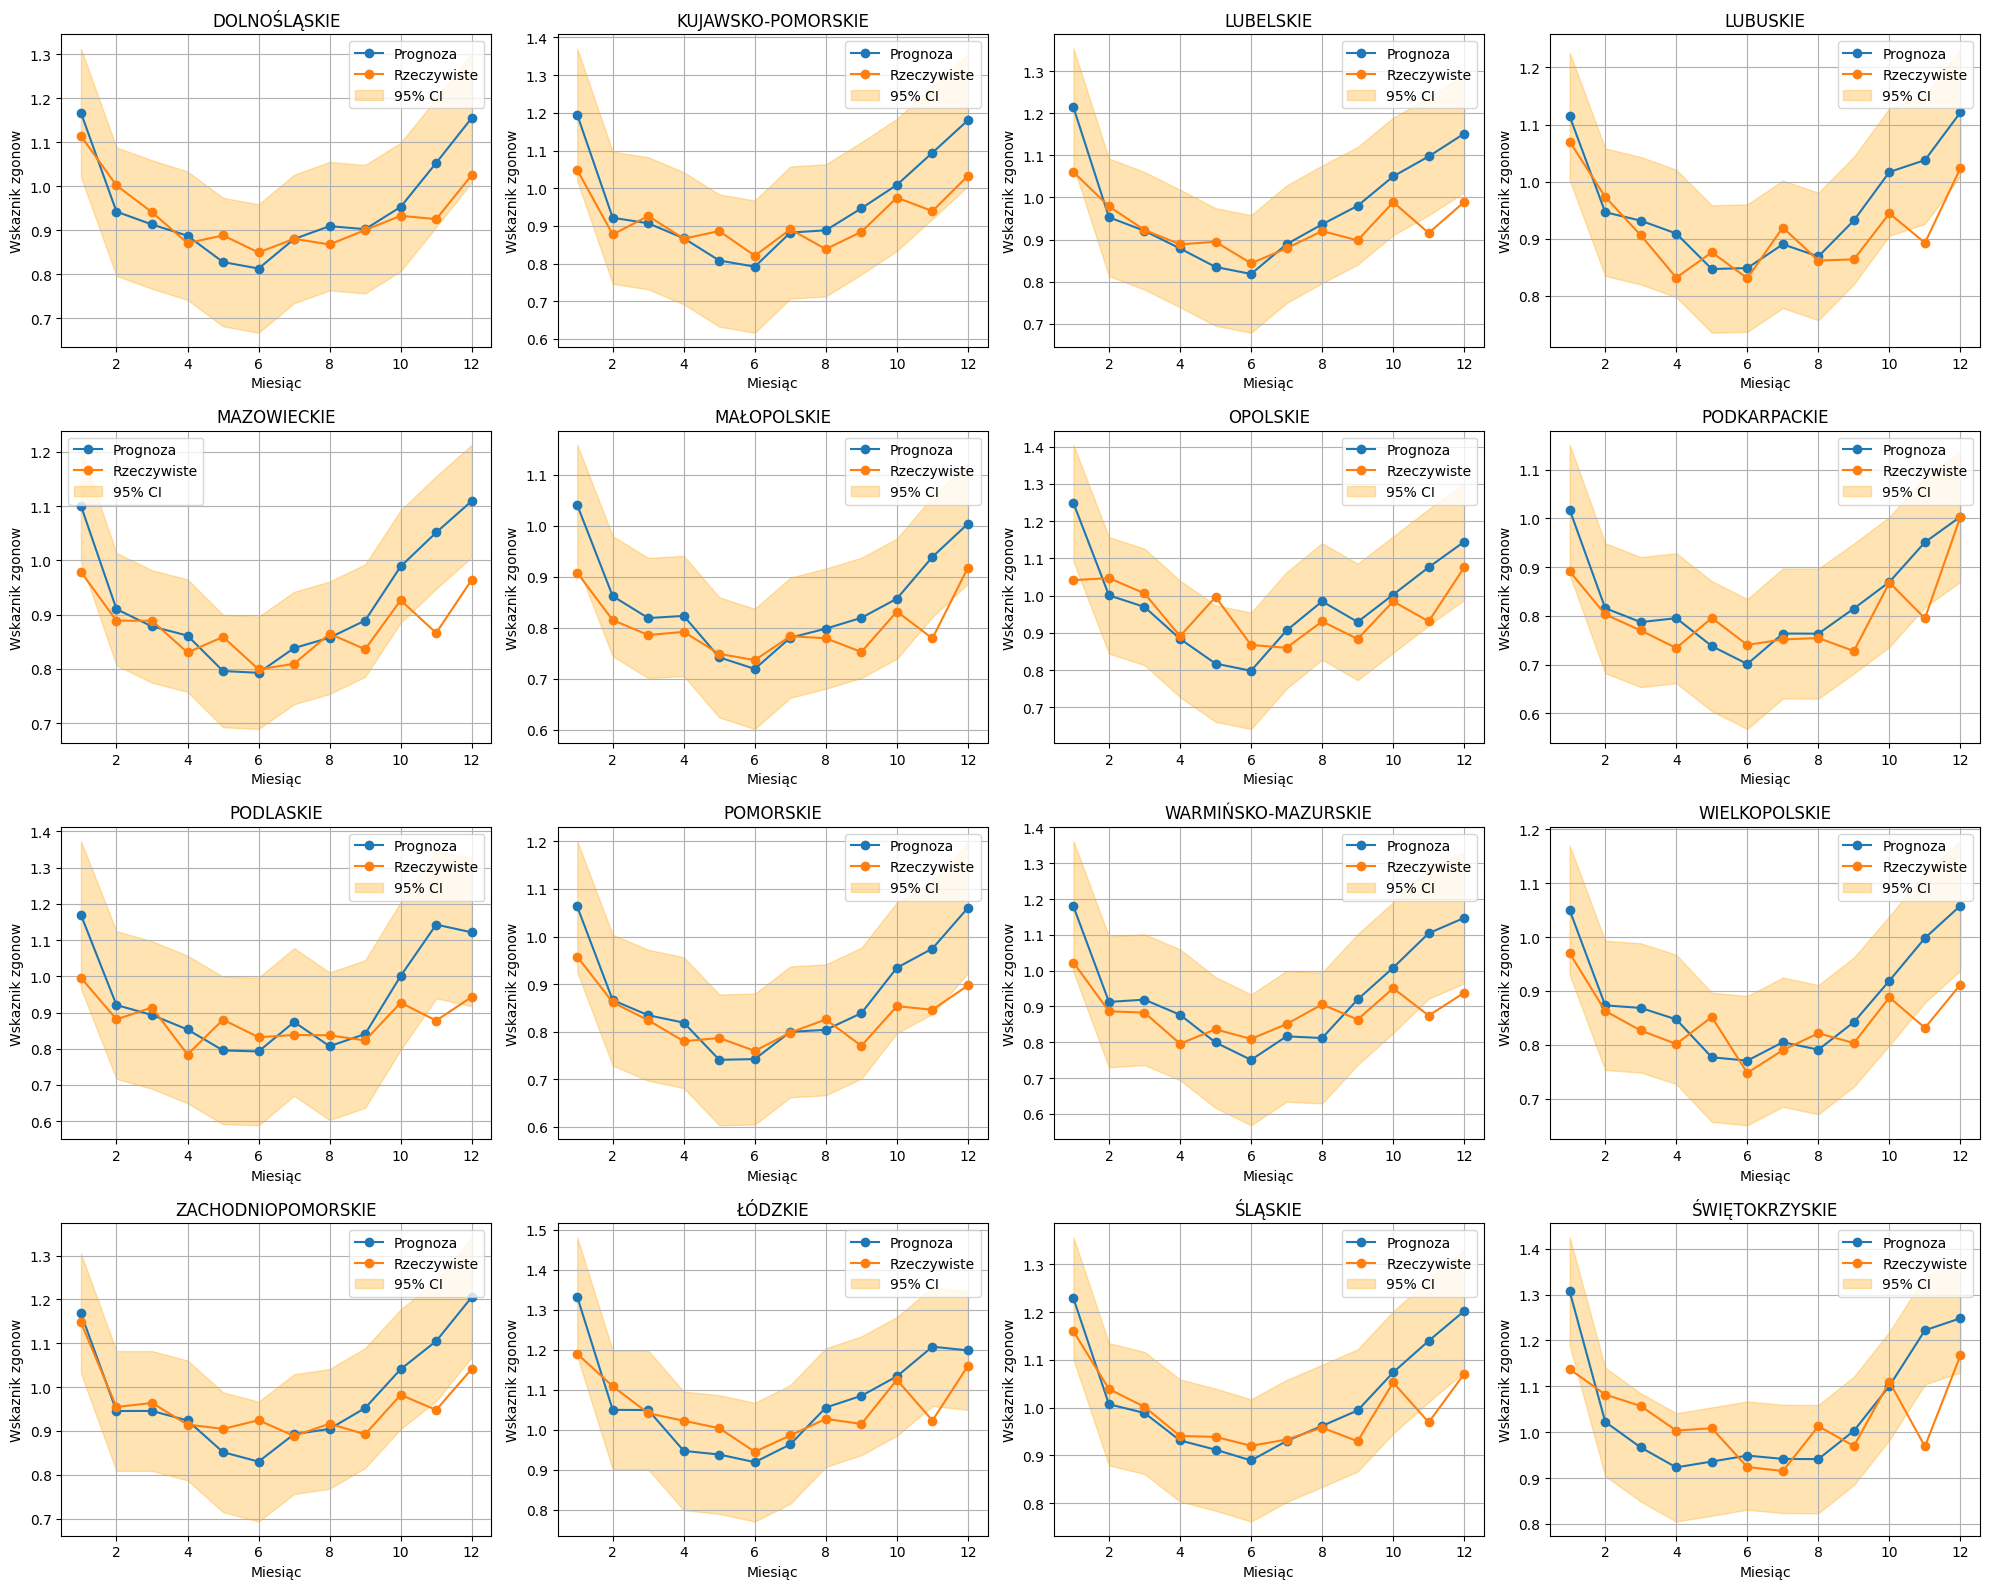

In [71]:
wojewodztwa = df_forecast_cp["Województwo"].unique()
fig, axes = plt.subplots(4,4, figsize=(20,16), sharey=False)
axes = axes.flatten()

for i, woj in enumerate(wojewodztwa):
    df_val_plot = df_all_lags[(df_all_lags["Nazwa województwa"]==woj) & (df_all_lags["Rok zgonu"]==2024)]
    df_w = df_forecast_cp[df_forecast_cp["Województwo"]==woj].sort_values("Miesiąc zgonu")
    axes[i].plot(df_w["Miesiąc zgonu"], df_w["Pred_mean"], marker="o", label="Prognoza")
    axes[i].plot(df_val_plot["Miesiąc zgonu"], df_val_plot["Wskaznik_zgonow_ogolem"], marker='o', label="Rzeczywiste")
    axes[i].fill_between(df_w["Miesiąc zgonu"], df_w["Pred_lower"], df_w["Pred_upper"], 
                         alpha=0.3, color="orange", label="95% CI")
    axes[i].set_title(woj)
    axes[i].set_xlabel("Miesiąc")
    axes[i].set_ylabel("Wskaznik zgonow")
    axes[i].grid(True)
    axes[i].legend()
    

plt.tight_layout()
plt.savefig("wykres_wojewodztwa.png", dpi=300)
plt.show()

In [73]:
metrics=[]

for woj in df_all_lags["Nazwa województwa"].unique():
    y_true=df_all_lags.loc[(df_all_lags["Rok zgonu"]==2024) & (df_all_lags["Nazwa województwa"]==woj), "Wskaznik_zgonow_ogolem"].values
    y_pred= df_forecast_cp.loc[df_forecast_cp["Województwo"]==woj, "Pred_mean"].values
    metrics.append({
        "Województwo": woj,
        "MAE" : mean_absolute_error(y_true, y_pred),
        "RMSE" : np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAPE" : np.mean(np.abs((y_true - y_pred) / np.maximum(1, y_true))) * 100,
    })


metrics_df=pd.DataFrame(metrics).sort_values("RMSE", ascending=False).reset_index(drop=True)
metrics_df.round(4)

,Województwo,MAE,RMSE,MAPE
0,PODLASKIE,0.0857,0.1139,8.5680
1,WARMIŃSKO-MAZURSKIE,0.0897,0.1121,8.9362
2,ŚWIĘTOKRZYSKIE,0.0809,0.1042,7.7236
3,OPOLSKIE,0.0769,0.0986,7.5660
4,LUBELSKIE,0.0659,0.0909,6.5144
5,KUJAWSKO-POMORSKIE,0.0646,0.0838,6.3670
6,MAZOWIECKIE,0.0613,0.0833,6.1309
7,ŁÓDZKIE,0.0608,0.0799,5.7186
8,ZACHODNIOPOMORSKIE,0.0550,0.0771,5.4241
9,POMORSKIE,0.0573,0.0764,5.7285


In [74]:
y_true = df_all_lags.loc[df_all_lags["Rok zgonu"]==2024, "Wskaznik_zgonow_ogolem"].values
y_pred = df_forecast_cp["Pred_mean"].values

mae_global = mean_absolute_error(y_true, y_pred)
rmse_global = np.sqrt(mean_squared_error(y_true, y_pred))
mape_global = np.mean(np.abs((y_true - y_pred) / np.maximum(1, y_true))) * 100 

metrics.insert(0, { "Województwo": "CAŁA POLSKA", "MAE": mae_global, "RMSE": rmse_global, "MAPE": mape_global })
metrics_df_all=pd.DataFrame(metrics).reset_index(drop=True)
metrics_df_all.round(4)

,Województwo,MAE,RMSE,MAPE
0,CAŁA POLSKA,0.0629,0.0849,6.2037
1,DOLNOŚLĄSKIE,0.0480,0.0631,4.7258
2,KUJAWSKO-POMORSKIE,0.0646,0.0838,6.3670
3,LUBELSKIE,0.0659,0.0909,6.5144
4,LUBUSKIE,0.0533,0.0657,5.2917
5,MAZOWIECKIE,0.0613,0.0833,6.1309
6,MAŁOPOLSKIE,0.0524,0.0712,5.2406
7,OPOLSKIE,0.0769,0.0986,7.5660
8,PODKARPACKIE,0.0484,0.0691,4.8382
9,PODLASKIE,0.0857,0.1139,8.5680
